In [1]:
import pandas as pd
import numpy as np
import warnings;warnings.simplefilter('ignore')
import os
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh,Dropout
import torch.optim as optim
import matplotlib.pyplot as plt

root = '../data/phase_2/raw/other/'
os.listdir(root)

['附件二.xlsx',
 '200mb201909.csv',
 'FCFC Import Naphtha Composition Lab_001~100_R2.xlsx',
 'Aroma-1 Unit 000 Split_Factor Calculation.xlsx',
 '200mb201701r2.csv',
 '附件一.xlsx']

# load data

In [2]:
data = pd.read_csv(root+"200mb201701r2.csv", encoding = 'big5', header = 0)
print('讀檔案 : ' + str(data.shape))
testdata = pd.read_csv(root+"200mb201909.csv", encoding = 'big5', header = 0)
# steam = dcs['ARO1-DCS-FIC55301'] + dcs['ARO1-DCS-FIC55501'] + dcs['ARO1-DCS-FIC55601']
# dcs['steam'] = steam
C9A = data['Feed    C9 Aromtics'] + data['Feed    C10+ Aromtics']
AROMA = data['Product    C9 Aromtics'] + data['Product    C10+ Aromtics']+ data['Product    Benzene']+ data['Product    Toluene']+ data['Product    Ethylbenzene']+ data['Product    P-Xylene']+ data['Product    M-Xylene']+ data['Product    O-Xylene']
data['C9A'] = C9A
data['AROMA'] = AROMA
C9A = testdata['Feed    C9 Aromtics'] + testdata['Feed    C10+ Aromtics']
AROMA = testdata['Product    C9 Aromtics'] + testdata['Product    C10+ Aromtics']+ testdata['Product    Benzene']+ testdata['Product    Toluene']+ testdata['Product    Ethylbenzene']+ testdata['Product    P-Xylene']+ testdata['Product    M-Xylene']+ testdata['Product    O-Xylene']
testdata['C9A'] = C9A
testdata['AROMA'] = AROMA

print ("Shape Of The Before Ouliers: ",data.shape)
data = data[(data["Naphtha Feed Rate, m3/hr"]<=100 )&(data["Naphtha Feed Rate, m3/hr"] >= 99)]
print ("Shape Of The After Ouliers: ",data.shape)
print ("Shape Of The Before Ouliers: ",testdata.shape)
testdata = testdata[(testdata["Naphtha Feed Rate, m3/hr"]<=100 )&(testdata["Naphtha Feed Rate, m3/hr"] >= 99)]
print ("Shape Of The After Ouliers: ",testdata.shape)
testdata.index = range(len(testdata))

讀檔案 : (829, 108)
Shape Of The Before Ouliers:  (829, 110)
Shape Of The After Ouliers:  (576, 110)
Shape Of The Before Ouliers:  (27, 110)
Shape Of The After Ouliers:  (20, 110)


# x_col

In [3]:
x_col  = [
"    N+2A in Naphtha Feed, wt%", #"ARO1-LIMS-s201-Naphthenes-ALL" + 2*"ARO1-LIMS-s201-Aromatics-ALL"
"    Chlorine in Fresh Catalyst, wt%", #"ARO1-LIMS-S307-CL"
"Carbon in Spent Catalyst, %",  #"ARO1-LIMS-S301-CARBON"  
"    C6P- in Naphtha Feed, wt%",  #"ARO1-LIMS-s201-Paraffins-6"  
"    3R211 Inlet Tem, oC",  #"ARO1-DCS-TIC20102 Setpoint"
"    3R212 Inlet Temp, oC", #"ARO1-DCS-TIC20202 Setpoint"
"    3R213 Inlet Temp, oC", #"ARO1-DCS-TIC20302 Setpoint"
"    3R214 Inlet Temp, oC", #"ARO1-DCS-TIC20402 Setpoint"
"Feed    Hydrogen",
"Feed    Methane",
"Feed    Ethane",
"Feed    Propane",
"Feed    n-Butane",
"Feed    i-Butane",
"Feed    C4 Naphthenes",
"Feed    n-Pentane",
"Feed    C5 i-Paraffins",
"Feed    C5 Naphthenes",
"Feed    n-Hexane",
"Feed    C6 i-Paraffins",
"Feed    C6 Naphthenes",
"Feed    Benzene",
"Feed    n-Heptane",
"Feed    C7 i-Paraffins",
"Feed    C7 Naphthenes",
"Feed    Toluene",
"Feed    n-Octane",
"Feed    C8 i-Paraffins",
"Feed    C8 Naphthenes",
"Feed    Ethylbenzene",
"Feed    P-Xylene",
"Feed    M-Xylene",
"Feed    O-Xylene",
"Feed    n-Nonane",
"Feed    C9 i-Paraffins",
"Feed    C9 Naphthenes",
"Feed    C9 Aromtics",
"Feed    C10+ n-Paraffins",
"Feed    C10+ i-Paraffins",
"Feed    C10+ Naphthenes",
"Feed    C10+ Aromtics",
"Product Separator Pressure, kg/cm2_g", #"ARO1-DCS-PIC21501 Setpoint"
# "Product Separator Temp, oC",
"H2/HC Ratio"                           #"ARO1-DCS-R211_HC"
         
         ]

In [4]:
x_col

['    N+2A in Naphtha Feed, wt%',
 '    Chlorine in Fresh Catalyst, wt%',
 'Carbon in Spent Catalyst, %',
 '    C6P- in Naphtha Feed, wt%',
 '    3R211 Inlet Tem, oC',
 '    3R212 Inlet Temp, oC',
 '    3R213 Inlet Temp, oC',
 '    3R214 Inlet Temp, oC',
 'Feed    Hydrogen',
 'Feed    Methane',
 'Feed    Ethane',
 'Feed    Propane',
 'Feed    n-Butane',
 'Feed    i-Butane',
 'Feed    C4 Naphthenes',
 'Feed    n-Pentane',
 'Feed    C5 i-Paraffins',
 'Feed    C5 Naphthenes',
 'Feed    n-Hexane',
 'Feed    C6 i-Paraffins',
 'Feed    C6 Naphthenes',
 'Feed    Benzene',
 'Feed    n-Heptane',
 'Feed    C7 i-Paraffins',
 'Feed    C7 Naphthenes',
 'Feed    Toluene',
 'Feed    n-Octane',
 'Feed    C8 i-Paraffins',
 'Feed    C8 Naphthenes',
 'Feed    Ethylbenzene',
 'Feed    P-Xylene',
 'Feed    M-Xylene',
 'Feed    O-Xylene',
 'Feed    n-Nonane',
 'Feed    C9 i-Paraffins',
 'Feed    C9 Naphthenes',
 'Feed    C9 Aromtics',
 'Feed    C10+ n-Paraffins',
 'Feed    C10+ i-Paraffins',
 'Feed    C10+ 

# y_col

In [5]:
script = '''
y1 = data["Product    Hydrogen"]
y2 = data["Product    Methane"]
y3 = data["Product    Ethane"]
y4 = data["Product    Propane"]
y5 = data["Product    n-Butane"]
y6 = data["Product    i-Butane"]
y7 = data["Product    C4 Naphthenes"]
y8 = data["Product    n-Pentane"]
y9 = data["Product    C5 i-Paraffins"]
y10 = data["Product    C5 Naphthenes"]
y11 = data["Product    n-Hexane"]
y12 = data["Product    C6 i-Paraffins"]
y13 = data["Product    C6 Naphthenes"]
y14 = data["Product    Benzene"]
y15 = data["Product    n-Heptane"]
y16 = data["Product    C7 i-Paraffins"]
y17 = data["Product    C7 Naphthenes"]
y18 = data["Product    Toluene"]
y19 = data["Product    n-Octane"]
y20 = data["Product    C8 i-Paraffins"]
y21 = data["Product    C8 Naphthenes"]
y22 = data["Product    Ethylbenzene"]
y23 = data["Product    P-Xylene"]
y24 = data["Product    M-Xylene"]
y25 = data["Product    O-Xylene"]
y26 = data["Product    n-Nonane"]
y27 = data["Product    C9 i-Paraffins"]
y28 = data["Product    C9 Naphthenes"]
y29 = data["Product    C9 Aromtics"]
y30 = data["Product    C10+ n-Paraffins"]
y31 = data["Product    C10+ i-Paraffins"]
y32 = data["Product    C10+ Naphthenes"]
y33 = data["Product    C10+ Aromtics"]
'''

In [6]:
y_col = []
for i in script.split('\n'):
    if ('[' in i)&(']'in i)&('Product' in i):
        s = i.index('["')+2
        e = i.index('"]')
        y_col.append(i[s:e])
y_col

['Product    Hydrogen',
 'Product    Methane',
 'Product    Ethane',
 'Product    Propane',
 'Product    n-Butane',
 'Product    i-Butane',
 'Product    C4 Naphthenes',
 'Product    n-Pentane',
 'Product    C5 i-Paraffins',
 'Product    C5 Naphthenes',
 'Product    n-Hexane',
 'Product    C6 i-Paraffins',
 'Product    C6 Naphthenes',
 'Product    Benzene',
 'Product    n-Heptane',
 'Product    C7 i-Paraffins',
 'Product    C7 Naphthenes',
 'Product    Toluene',
 'Product    n-Octane',
 'Product    C8 i-Paraffins',
 'Product    C8 Naphthenes',
 'Product    Ethylbenzene',
 'Product    P-Xylene',
 'Product    M-Xylene',
 'Product    O-Xylene',
 'Product    n-Nonane',
 'Product    C9 i-Paraffins',
 'Product    C9 Naphthenes',
 'Product    C9 Aromtics',
 'Product    C10+ n-Paraffins',
 'Product    C10+ i-Paraffins',
 'Product    C10+ Naphthenes',
 'Product    C10+ Aromtics']

# get  cleaned data

In [7]:
X_train = data[x_col]
X_test = testdata[x_col]
y_train = data[y_col]
y_test = testdata[y_col]
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((576, 43), (576, 33), (20, 43), (20, 33))

# group x_col

In [8]:
sum_col = ['Feed    Methane','Feed    Ethane','Feed    n-Butane',
          'Feed    i-Butane','Feed    C4 Naphthenes','Feed    n-Pentane','Feed    C5 i-Paraffins',
          'Feed    C5 Naphthenes','Feed    C6 i-Paraffins']

In [9]:
print(X_train.shape)
X_train['Feed    C6 i-Paraffins'] = X_train[sum_col].sum(axis=1)
X_train = X_train.drop(sum_col,axis=1)
print(X_train.shape)

(576, 43)
(576, 34)


In [10]:
print(X_test.shape)
X_test['Feed    C6 i-Paraffins'] = X_test[sum_col].sum(axis=1)
X_test = X_test.drop(sum_col,axis=1)
print(X_test.shape)

(20, 43)
(20, 34)


In [11]:
x_col = X_train.columns.tolist()
print(len(x_col))

34


# scale data

In [12]:
from sklearn.preprocessing import MinMaxScaler

mm_x = MinMaxScaler()
mm_x.fit(X_train.append(X_test))

mm_y = MinMaxScaler()
mm_y.fit(y_train.append(y_test))

X_train[:] = mm_x.transform(X_train[:])
X_test[:] = mm_x.transform(X_test[:])

y_train[:] = mm_y.transform(y_train[:])
y_test[:] = mm_y.transform(y_test[:])

# torch data_iter

In [13]:
X_train = torch.tensor(X_train.values,dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float).cuda()

y_train = torch.tensor(y_train.values,dtype=torch.float).cuda()
y_test = torch.tensor(y_test.values,dtype=torch.float).cuda()

datasets = torch.utils.data.TensorDataset(X_train, y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=128,shuffle=True)

# define model

In [14]:
class model4333(nn.Module):
    def __init__(self,input_shape,output_shape):
        super(model4333,self).__init__()
        self.fc1 = Linear(input_shape,256)
        self.fc2 = Linear(256,128)
        self.fc3 = Linear(128,output_shape)
        self.dropout = Dropout(0.5)
    
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))
        return x

In [15]:
def init_weights(m):
    if hasattr(m,'weight'):
        torch.nn.init.xavier_uniform(m.weight)
    if hasattr(m,'bias'):
        m.bias.data.fill_(0.01)

In [16]:
net = model4333(len(x_col),len(y_col)).cuda()
net.apply(init_weights)

model4333(
  (fc1): Linear(in_features=34, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=33, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
net(X_test[0])

tensor([0.5127, 0.4926, 0.5527, 0.5425, 0.4309, 0.4608, 0.3666, 0.4740, 0.4103,
        0.4084, 0.3806, 0.4677, 0.4888, 0.5506, 0.5081, 0.5052, 0.5058, 0.5226,
        0.5664, 0.4433, 0.6284, 0.5066, 0.5542, 0.4302, 0.5551, 0.4322, 0.5239,
        0.4444, 0.5485, 0.4973, 0.5051, 0.4203, 0.5588], device='cuda:0',
       grad_fn=<SigmoidBackward>)

# loss and opt

In [18]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

In [19]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.0589 valid loss 0.0477
record net
epochs 1 train loss 0.0448 valid loss 0.0337
record net
epochs 2 train loss 0.0364 valid loss 0.0249
record net
epochs 3 train loss 0.0316 valid loss 0.0205
record net
epochs 4 train loss 0.0289 valid loss 0.0189
record net
epochs 5 train loss 0.0268 valid loss 0.0185
record net
epochs 6 train loss 0.0249 valid loss 0.0182
record net
epochs 7 train loss 0.0235 valid loss 0.0175
record net
epochs 8 train loss 0.0222 valid loss 0.0167
record net
epochs 9 train loss 0.0211 valid loss 0.0157
record net
epochs 10 train loss 0.0207 valid loss 0.0155
record net
epochs 11 train loss 0.0199 valid loss 0.0149
record net
epochs 12 train loss 0.0191 valid loss 0.0143
record net
epochs 13 train loss 0.0184 valid loss 0.0141
record net
epochs 14 train loss 0.0177 valid loss 0.0137
record net
epochs 15 train loss 0.0177 valid loss 0.0132
record net
epochs 16 train loss 0.0169 valid loss 0.0130
record net
epochs 17 train loss 0.0166 valid loss 0.

epochs 162 train loss 0.0089 valid loss 0.0066
epochs 163 train loss 0.0089 valid loss 0.0064
record net
epochs 164 train loss 0.0089 valid loss 0.0066
epochs 165 train loss 0.0088 valid loss 0.0065
epochs 166 train loss 0.0088 valid loss 0.0067
epochs 167 train loss 0.0088 valid loss 0.0065
epochs 168 train loss 0.0088 valid loss 0.0065
epochs 169 train loss 0.0090 valid loss 0.0066
epochs 170 train loss 0.0088 valid loss 0.0064
epochs 171 train loss 0.0088 valid loss 0.0066
epochs 172 train loss 0.0087 valid loss 0.0065
epochs 173 train loss 0.0088 valid loss 0.0068
epochs 174 train loss 0.0087 valid loss 0.0065
epochs 175 train loss 0.0086 valid loss 0.0065
epochs 176 train loss 0.0086 valid loss 0.0064
record net
epochs 177 train loss 0.0090 valid loss 0.0063
record net
epochs 178 train loss 0.0085 valid loss 0.0064
epochs 179 train loss 0.0086 valid loss 0.0066
epochs 180 train loss 0.0086 valid loss 0.0064
epochs 181 train loss 0.0086 valid loss 0.0064
epochs 182 train loss 0.008

epochs 330 train loss 0.0075 valid loss 0.0052
record net
epochs 331 train loss 0.0073 valid loss 0.0052
epochs 332 train loss 0.0073 valid loss 0.0052
record net
epochs 333 train loss 0.0073 valid loss 0.0051
record net
epochs 334 train loss 0.0070 valid loss 0.0051
epochs 335 train loss 0.0073 valid loss 0.0051
epochs 336 train loss 0.0075 valid loss 0.0052
epochs 337 train loss 0.0073 valid loss 0.0052
epochs 338 train loss 0.0072 valid loss 0.0052
epochs 339 train loss 0.0073 valid loss 0.0052
epochs 340 train loss 0.0073 valid loss 0.0052
epochs 341 train loss 0.0072 valid loss 0.0052
epochs 342 train loss 0.0073 valid loss 0.0051
epochs 343 train loss 0.0075 valid loss 0.0051
epochs 344 train loss 0.0076 valid loss 0.0052
epochs 345 train loss 0.0073 valid loss 0.0052
epochs 346 train loss 0.0074 valid loss 0.0053
epochs 347 train loss 0.0075 valid loss 0.0053
epochs 348 train loss 0.0074 valid loss 0.0051
epochs 349 train loss 0.0073 valid loss 0.0051
record net
epochs 350 train

epochs 501 train loss 0.0065 valid loss 0.0045
epochs 502 train loss 0.0065 valid loss 0.0045
epochs 503 train loss 0.0066 valid loss 0.0045
epochs 504 train loss 0.0067 valid loss 0.0044
record net
epochs 505 train loss 0.0067 valid loss 0.0046
epochs 506 train loss 0.0065 valid loss 0.0045
epochs 507 train loss 0.0068 valid loss 0.0044
record net
epochs 508 train loss 0.0066 valid loss 0.0045
epochs 509 train loss 0.0065 valid loss 0.0044
epochs 510 train loss 0.0067 valid loss 0.0045
epochs 511 train loss 0.0065 valid loss 0.0045
epochs 512 train loss 0.0065 valid loss 0.0044
epochs 513 train loss 0.0067 valid loss 0.0044
epochs 514 train loss 0.0067 valid loss 0.0046
epochs 515 train loss 0.0067 valid loss 0.0043
record net
epochs 516 train loss 0.0065 valid loss 0.0043
epochs 517 train loss 0.0066 valid loss 0.0043
epochs 518 train loss 0.0065 valid loss 0.0045
epochs 519 train loss 0.0067 valid loss 0.0044
epochs 520 train loss 0.0063 valid loss 0.0044
epochs 521 train loss 0.006

epochs 672 train loss 0.0056 valid loss 0.0039
epochs 673 train loss 0.0059 valid loss 0.0038
epochs 674 train loss 0.0059 valid loss 0.0039
epochs 675 train loss 0.0060 valid loss 0.0039
epochs 676 train loss 0.0059 valid loss 0.0039
epochs 677 train loss 0.0059 valid loss 0.0040
epochs 678 train loss 0.0060 valid loss 0.0038
epochs 679 train loss 0.0059 valid loss 0.0037
record net
epochs 680 train loss 0.0060 valid loss 0.0039
epochs 681 train loss 0.0060 valid loss 0.0040
epochs 682 train loss 0.0060 valid loss 0.0038
epochs 683 train loss 0.0060 valid loss 0.0038
epochs 684 train loss 0.0059 valid loss 0.0039
epochs 685 train loss 0.0060 valid loss 0.0039
epochs 686 train loss 0.0062 valid loss 0.0039
epochs 687 train loss 0.0060 valid loss 0.0039
epochs 688 train loss 0.0063 valid loss 0.0038
epochs 689 train loss 0.0058 valid loss 0.0038
epochs 690 train loss 0.0059 valid loss 0.0038
epochs 691 train loss 0.0058 valid loss 0.0038
epochs 692 train loss 0.0059 valid loss 0.0038
ep

epochs 842 train loss 0.0056 valid loss 0.0034
epochs 843 train loss 0.0055 valid loss 0.0034
epochs 844 train loss 0.0056 valid loss 0.0035
epochs 845 train loss 0.0056 valid loss 0.0034
epochs 846 train loss 0.0055 valid loss 0.0035
epochs 847 train loss 0.0055 valid loss 0.0035
epochs 848 train loss 0.0057 valid loss 0.0036
epochs 849 train loss 0.0056 valid loss 0.0034
epochs 850 train loss 0.0056 valid loss 0.0034
epochs 851 train loss 0.0057 valid loss 0.0034
epochs 852 train loss 0.0056 valid loss 0.0034
epochs 853 train loss 0.0054 valid loss 0.0035
epochs 854 train loss 0.0056 valid loss 0.0034
epochs 855 train loss 0.0055 valid loss 0.0033
record net
epochs 856 train loss 0.0058 valid loss 0.0034
epochs 857 train loss 0.0056 valid loss 0.0033
record net
epochs 858 train loss 0.0056 valid loss 0.0033
epochs 859 train loss 0.0056 valid loss 0.0034
epochs 860 train loss 0.0055 valid loss 0.0035
epochs 861 train loss 0.0056 valid loss 0.0035
epochs 862 train loss 0.0056 valid los

epochs 1020 train loss 0.0052 valid loss 0.0032
epochs 1021 train loss 0.0053 valid loss 0.0031
epochs 1022 train loss 0.0051 valid loss 0.0032
epochs 1023 train loss 0.0051 valid loss 0.0031
epochs 1024 train loss 0.0053 valid loss 0.0032
epochs 1025 train loss 0.0052 valid loss 0.0031
epochs 1026 train loss 0.0054 valid loss 0.0033
epochs 1027 train loss 0.0053 valid loss 0.0032
epochs 1028 train loss 0.0052 valid loss 0.0030
epochs 1029 train loss 0.0053 valid loss 0.0030
record net
epochs 1030 train loss 0.0054 valid loss 0.0032
epochs 1031 train loss 0.0053 valid loss 0.0031
epochs 1032 train loss 0.0052 valid loss 0.0031
epochs 1033 train loss 0.0053 valid loss 0.0031
epochs 1034 train loss 0.0054 valid loss 0.0030
record net
epochs 1035 train loss 0.0051 valid loss 0.0031
epochs 1036 train loss 0.0050 valid loss 0.0031
epochs 1037 train loss 0.0050 valid loss 0.0030
epochs 1038 train loss 0.0053 valid loss 0.0030
epochs 1039 train loss 0.0052 valid loss 0.0031
epochs 1040 train 

epochs 1197 train loss 0.0049 valid loss 0.0028
epochs 1198 train loss 0.0048 valid loss 0.0027
record net
epochs 1199 train loss 0.0049 valid loss 0.0029
epochs 1200 train loss 0.0049 valid loss 0.0029
epochs 1201 train loss 0.0048 valid loss 0.0029
epochs 1202 train loss 0.0051 valid loss 0.0028
epochs 1203 train loss 0.0050 valid loss 0.0028
epochs 1204 train loss 0.0051 valid loss 0.0029
epochs 1205 train loss 0.0052 valid loss 0.0028
epochs 1206 train loss 0.0049 valid loss 0.0028
epochs 1207 train loss 0.0050 valid loss 0.0028
epochs 1208 train loss 0.0052 valid loss 0.0029
epochs 1209 train loss 0.0050 valid loss 0.0030
epochs 1210 train loss 0.0052 valid loss 0.0029
epochs 1211 train loss 0.0049 valid loss 0.0029
epochs 1212 train loss 0.0049 valid loss 0.0029
epochs 1213 train loss 0.0049 valid loss 0.0030
epochs 1214 train loss 0.0051 valid loss 0.0028
epochs 1215 train loss 0.0050 valid loss 0.0029
epochs 1216 train loss 0.0049 valid loss 0.0029
epochs 1217 train loss 0.0050

epochs 1376 train loss 0.0047 valid loss 0.0026
epochs 1377 train loss 0.0046 valid loss 0.0025
epochs 1378 train loss 0.0049 valid loss 0.0025
epochs 1379 train loss 0.0048 valid loss 0.0026
epochs 1380 train loss 0.0047 valid loss 0.0026
epochs 1381 train loss 0.0048 valid loss 0.0026
epochs 1382 train loss 0.0049 valid loss 0.0026
epochs 1383 train loss 0.0049 valid loss 0.0025
epochs 1384 train loss 0.0048 valid loss 0.0026
epochs 1385 train loss 0.0046 valid loss 0.0026
epochs 1386 train loss 0.0047 valid loss 0.0027
epochs 1387 train loss 0.0048 valid loss 0.0026
epochs 1388 train loss 0.0048 valid loss 0.0027
epochs 1389 train loss 0.0046 valid loss 0.0027
epochs 1390 train loss 0.0047 valid loss 0.0026
epochs 1391 train loss 0.0049 valid loss 0.0026
epochs 1392 train loss 0.0048 valid loss 0.0026
epochs 1393 train loss 0.0048 valid loss 0.0026
epochs 1394 train loss 0.0045 valid loss 0.0027
epochs 1395 train loss 0.0046 valid loss 0.0027
epochs 1396 train loss 0.0047 valid loss

epochs 1552 train loss 0.0045 valid loss 0.0024
epochs 1553 train loss 0.0045 valid loss 0.0023
epochs 1554 train loss 0.0046 valid loss 0.0024
epochs 1555 train loss 0.0046 valid loss 0.0024
epochs 1556 train loss 0.0045 valid loss 0.0023
record net
epochs 1557 train loss 0.0046 valid loss 0.0024
epochs 1558 train loss 0.0047 valid loss 0.0024
epochs 1559 train loss 0.0048 valid loss 0.0024
epochs 1560 train loss 0.0046 valid loss 0.0024
epochs 1561 train loss 0.0050 valid loss 0.0023
epochs 1562 train loss 0.0045 valid loss 0.0024
epochs 1563 train loss 0.0046 valid loss 0.0025
epochs 1564 train loss 0.0047 valid loss 0.0023
record net
epochs 1565 train loss 0.0046 valid loss 0.0025
epochs 1566 train loss 0.0046 valid loss 0.0024
epochs 1567 train loss 0.0047 valid loss 0.0024
epochs 1568 train loss 0.0046 valid loss 0.0023
epochs 1569 train loss 0.0044 valid loss 0.0023
epochs 1570 train loss 0.0047 valid loss 0.0023
epochs 1571 train loss 0.0046 valid loss 0.0024
epochs 1572 train 

epochs 1730 train loss 0.0044 valid loss 0.0023
epochs 1731 train loss 0.0044 valid loss 0.0024
epochs 1732 train loss 0.0045 valid loss 0.0024
epochs 1733 train loss 0.0045 valid loss 0.0023
epochs 1734 train loss 0.0045 valid loss 0.0024
epochs 1735 train loss 0.0046 valid loss 0.0023
epochs 1736 train loss 0.0044 valid loss 0.0024
epochs 1737 train loss 0.0044 valid loss 0.0024
epochs 1738 train loss 0.0047 valid loss 0.0023
epochs 1739 train loss 0.0044 valid loss 0.0022
epochs 1740 train loss 0.0044 valid loss 0.0022
epochs 1741 train loss 0.0044 valid loss 0.0023
epochs 1742 train loss 0.0044 valid loss 0.0023
epochs 1743 train loss 0.0045 valid loss 0.0023
epochs 1744 train loss 0.0044 valid loss 0.0022
epochs 1745 train loss 0.0044 valid loss 0.0023
epochs 1746 train loss 0.0045 valid loss 0.0023
epochs 1747 train loss 0.0046 valid loss 0.0023
epochs 1748 train loss 0.0045 valid loss 0.0023
epochs 1749 train loss 0.0044 valid loss 0.0021
record net
epochs 1750 train loss 0.0045

epochs 1904 train loss 0.0044 valid loss 0.0022
epochs 1905 train loss 0.0046 valid loss 0.0021
epochs 1906 train loss 0.0044 valid loss 0.0022
epochs 1907 train loss 0.0042 valid loss 0.0023
epochs 1908 train loss 0.0046 valid loss 0.0022
epochs 1909 train loss 0.0042 valid loss 0.0022
epochs 1910 train loss 0.0045 valid loss 0.0022
epochs 1911 train loss 0.0044 valid loss 0.0021
epochs 1912 train loss 0.0044 valid loss 0.0023
epochs 1913 train loss 0.0044 valid loss 0.0022
epochs 1914 train loss 0.0043 valid loss 0.0023
epochs 1915 train loss 0.0045 valid loss 0.0022
epochs 1916 train loss 0.0042 valid loss 0.0021
epochs 1917 train loss 0.0043 valid loss 0.0022
epochs 1918 train loss 0.0043 valid loss 0.0021
epochs 1919 train loss 0.0046 valid loss 0.0021
epochs 1920 train loss 0.0044 valid loss 0.0022
epochs 1921 train loss 0.0043 valid loss 0.0021
epochs 1922 train loss 0.0043 valid loss 0.0023
epochs 1923 train loss 0.0044 valid loss 0.0022
epochs 1924 train loss 0.0044 valid loss

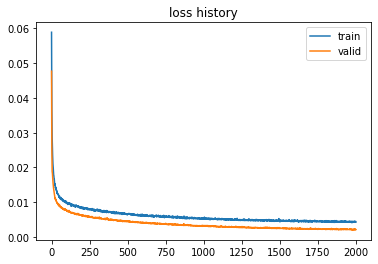

In [20]:
net = train(net,train_iter,train_iter,loss_function,optimizer,num_epochs=2000)

# make prediction

In [21]:
y_pred = net(X_test).cpu().detach().numpy()
y_pred = mm_y.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2570.281738,809.604370,2248.246582,2829.455078,1121.593384,1066.235229,1.078425,1700.134766,2575.158447,37.027390,...,10113.442383,5292.500488,7.691960,25.572769,20.527189,9392.476562,92.661507,189.635086,127.380112,1821.751099
1,2568.565674,821.107666,2247.023926,2765.768555,1139.721558,1092.523071,1.097369,1689.393921,2561.115479,36.098186,...,10142.819336,5288.895020,8.074911,27.269241,20.588343,9438.040039,93.772896,193.177002,129.202393,1832.818604
2,2583.992188,781.575012,2209.318359,2860.459961,1093.054565,1026.217529,1.066441,1683.907837,2548.185547,36.855713,...,10266.083008,5334.181152,6.848237,23.516626,18.868420,9239.918945,93.676979,189.831573,127.418968,1765.874268
3,2573.735596,820.358887,2231.850830,2780.442383,1123.729736,1063.630737,1.074602,1687.425781,2559.392578,35.795753,...,10130.073242,5295.624023,8.339573,28.512247,20.648420,9475.931641,92.818619,191.377853,127.996727,1840.438354
4,2577.452393,822.569885,2244.199463,2824.304199,1082.654175,1012.689209,1.069610,1699.019897,2577.608154,34.358597,...,10171.770508,5287.781250,8.353992,28.906725,19.677374,9553.414062,90.154129,184.376968,123.488640,1850.180298


In [22]:
y_real = y_test.cpu().detach().numpy()
y_real = mm_y.inverse_transform(y_real)
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,Product Hydrogen,Product Methane,Product Ethane,Product Propane,Product n-Butane,Product i-Butane,Product C4 Naphthenes,Product n-Pentane,Product C5 i-Paraffins,Product C5 Naphthenes,...,Product M-Xylene,Product O-Xylene,Product n-Nonane,Product C9 i-Paraffins,Product C9 Naphthenes,Product C9 Aromtics,Product C10+ n-Paraffins,Product C10+ i-Paraffins,Product C10+ Naphthenes,Product C10+ Aromtics
0,2585.543945,783.050415,2167.787842,2652.459229,1190.827881,1204.990967,0.993305,1659.135864,2504.534424,37.759483,...,10368.238281,5203.674805,7.924977,28.818098,21.613575,9198.000977,89.397423,174.555038,119.134483,1788.525391
1,2603.471924,802.383057,2194.137207,2121.544189,1468.593384,1563.974609,0.991749,1688.823730,2555.859619,37.822845,...,10326.885742,5182.920898,8.026574,27.728163,21.890656,9217.683594,88.513573,172.790543,118.854881,1775.654785
2,2583.133789,875.061646,2180.788086,2890.277100,1133.260010,1070.766968,1.117023,1658.076660,2512.558350,37.748615,...,10314.416992,5176.662598,7.963961,27.511864,20.995895,9191.858398,94.822845,185.389496,127.154457,1778.275024
3,2569.629395,888.716736,2207.623291,2813.154541,1111.260864,1039.724121,0.992776,1702.433350,2574.746338,39.185349,...,10330.272461,5184.620117,7.294888,25.532106,21.155176,9204.890625,87.612442,169.090637,118.264397,1773.150635
4,2565.668457,887.869019,2179.576416,2809.469482,1067.980591,977.900513,1.119704,1716.807129,2595.738525,39.400585,...,10360.566406,5199.824219,7.954566,28.925694,20.971128,9265.553711,88.705460,173.766342,119.839462,1788.048950


# metric

In [23]:
from sklearn.metrics import r2_score,mean_squared_error
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [24]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Product Hydrogen,0.447548,1777.54,1.30384
Product Methane,-0.265042,12383.2,10.089
Product Ethane,0.599523,6433.45,3.00227
Product Propane,-0.180578,95718,10.0183
Product n-Butane,-0.688841,25876.2,9.93737
Product i-Butane,-0.525037,47324.6,13.0915
Product C4 Naphthenes,0.0237147,0.685482,9.12679
Product n-Pentane,0.641317,15771.2,4.85433
Product C5 i-Paraffins,0.640511,33924.3,4.76066
Product C5 Naphthenes,-2.1067,6.92808,5.85004
